In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.split import split_phenotypes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct --no-maf-flip -p 10 -t 2 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[ 0.64763818  0.39041655]
 [ 0.91854999 -1.65104023]
 [ 0.49930683 -1.59254097]
 ...
 [ 0.46882711  0.31581469]
 [-0.64530406 -0.88993104]
 [ 1.96796977  1.93674461]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
individuals = samples_to_individuals(sample_nodes_df_multi)
normalized_individual_multi_normal = normalize_genetic_values(individuals)


First, we will demonstrate how to simulate user-defined noise for multiple causal mutations (if the user does not want to use the h2 heritability feature). In this case, the user must specify the mean and covariance matrix to be used.

In [6]:
std_means = np.array([0, 0])
std_covariances = np.array([[1, 0], [0, 1]])
phenotypes_user_defined_multi_normal = sim_env_noise(individuals, user_defined=True, means=std_means, cov=std_covariances) #simulates noise from the multivariate standard normal distribution with means of zero and an identity matrix for covariance
phenotypes_user_defined_multi_normal_df = phenotypes_user_defined_multi_normal.phenotype_df
phenotypes_user_defined_multi_normal_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-0.218480,-38.160859
1,1,0,-23.087706,0.134446,-22.953260
2,0,1,-19.908226,1.391961,-18.516266
3,1,1,-22.240029,-0.222336,-22.462365
4,0,2,-9.933216,1.025427,-8.907789
...,...,...,...,...,...
395,1,197,6.632294,0.651767,7.284062
396,0,198,-28.121344,0.818938,-27.302406
397,1,198,-17.527029,0.955091,-16.571938
398,0,199,-10.601552,-0.660198,-11.261750


The user can extract the h2 assigned to any phenotype simulation as follows.

In [7]:
user_defined_multi_h2 = phenotypes_user_defined_multi_normal.get_h2()
print(user_defined_multi_h2)

[1.02120395 1.00660111]


In [8]:
split_phenotypes(phenotypes_user_defined_multi_normal_df, return_print=True)

     causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379            -0.218480   
2                     0              1     -19.908226             1.391961   
4                     0              2      -9.933216             1.025427   
6                     0              3     -16.476328            -2.167751   
8                     0              4     -39.004838             0.150870   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154             0.029164   
392                   0            196     -27.360933            -1.880664   
394                   0            197     -23.888838            -1.670374   
396                   0            198     -28.121344             0.818938   
398                   0            199     -10.601552            -0.660198   

     phenotype  
0   -38.160859  
2   -18.516266  
4    -8.9077

In [9]:
split_phenotypes_list = split_phenotypes(phenotypes_user_defined_multi_normal_df, return_list=True)
split_phenotypes_list[0] #the first dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-0.218480,-38.160859
2,0,1,-19.908226,1.391961,-18.516266
4,0,2,-9.933216,1.025427,-8.907789
6,0,3,-16.476328,-2.167751,-18.644079
8,0,4,-39.004838,0.150870,-38.853968
...,...,...,...,...,...
390,0,195,-20.002154,0.029164,-19.972990
392,0,196,-27.360933,-1.880664,-29.241596
394,0,197,-23.888838,-1.670374,-25.559212
396,0,198,-28.121344,0.818938,-27.302406


In [10]:
split_phenotypes_list[1] #the second dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
1,1,0,-23.087706,0.134446,-22.953260
3,1,1,-22.240029,-0.222336,-22.462365
5,1,2,-30.900956,-0.270212,-31.171169
7,1,3,-27.909054,-0.148026,-28.057079
9,1,4,10.082859,1.716488,11.799348
...,...,...,...,...,...
391,1,195,0.216175,1.963045,2.179220
393,1,196,-26.683542,0.464624,-26.218918
395,1,197,6.632294,0.651767,7.284062
397,1,198,-17.527029,0.955091,-16.571938


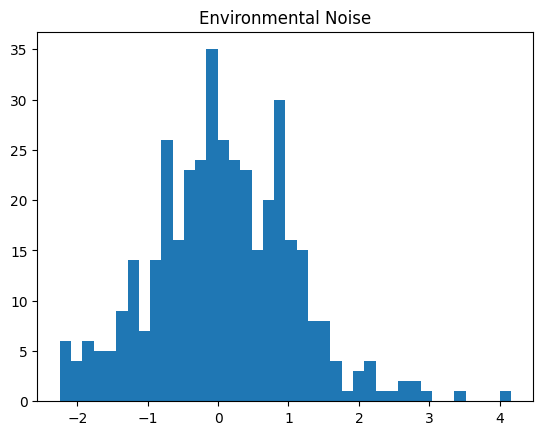

Mean of noise: 0.07427870992098529
Standard deviation of noise: 1.0095500536355282


In [11]:

plt.hist(phenotypes_user_defined_multi_normal_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].std()))

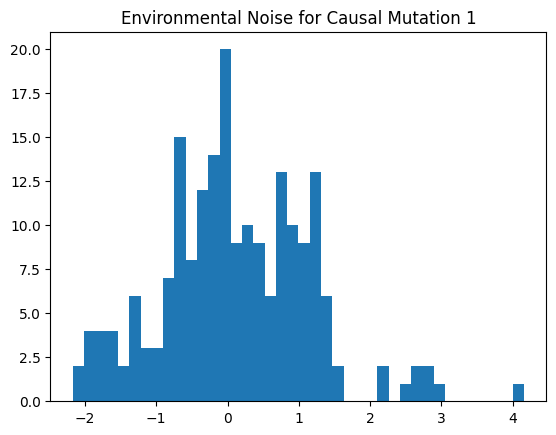

Mean of noise: 0.11434210673514969
Standard deviation of noise: 1.04572931061628


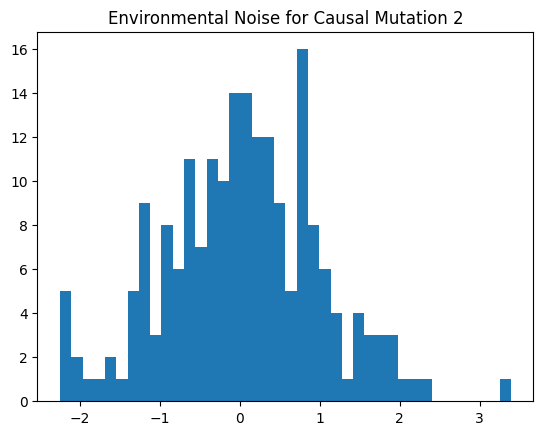

Mean of noise: 0.03421531310682089
Standard deviation of noise: 0.9729995436492032


In [12]:
df_dict_test = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_df.groupby('causal_mutation_id')}

num = len(df_dict_test)

for i in range(num):
  temp_df = df_dict_test[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [13]:
phenotypes_user_defined_multi_normal_df_normalized = normalize(phenotypes_user_defined_multi_normal)
phenotypes_user_defined_multi_normal_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.480984,-0.031933,-1.512917
1,1,0,-0.980116,0.008424,-0.971692
2,0,1,0.249346,0.122584,0.371930
3,1,1,-0.908871,-0.021562,-0.930434
4,0,2,1.206421,0.087416,1.293838
...,...,...,...,...,...
395,1,197,1.517742,0.051903,1.569645
396,0,198,-0.538681,0.067604,-0.471077
397,1,198,-0.512761,0.077396,-0.435365
398,0,199,1.142296,-0.074315,1.067981


In [14]:
means = np.array([0, 0])
covariance = np.array([[1, 0.25], [0.25, 1]])
phenotypes_user_defined_multi_normal_special_cov = sim_env_noise(individuals, user_defined=True, means=means, cov=covariance) #simulating noise using a user-defined covariance matrix instead of the identity matrix
phenotypes_user_defined_multi_normal_special_cov_df = phenotypes_user_defined_multi_normal_special_cov.phenotype_df
phenotypes_user_defined_multi_normal_special_cov_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.905785,-37.036594
1,1,0,-23.087706,-0.244666,-23.332372
2,0,1,-19.908226,-0.280952,-20.189178
3,1,1,-22.240029,1.465882,-20.774147
4,0,2,-9.933216,0.557240,-9.375977
...,...,...,...,...,...
395,1,197,6.632294,0.591774,7.224068
396,0,198,-28.121344,-0.854867,-28.976212
397,1,198,-17.527029,0.187281,-17.339748
398,0,199,-10.601552,0.417387,-10.184166


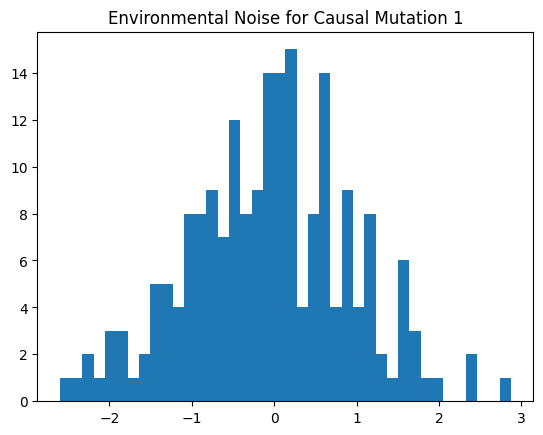

Mean of noise: -0.0604580865372308
Standard deviation of noise: 0.9884294857787712


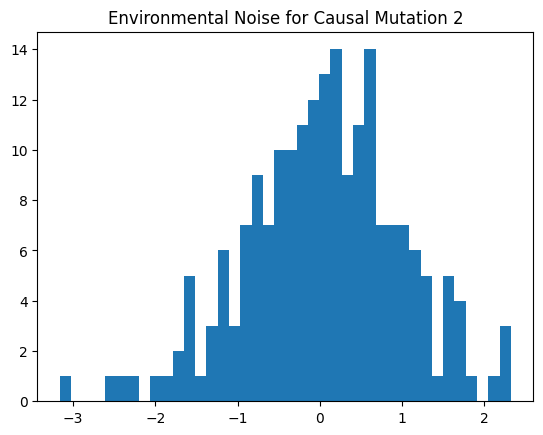

Mean of noise: 0.04672731666568628
Standard deviation of noise: 0.9563826660038907


In [15]:
df_dict_test_cov = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_special_cov_df.groupby('causal_mutation_id')}

num = len(df_dict_test_cov)

for i in range(num):
  temp_df = df_dict_test_cov[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [16]:
phenotypes_user_defined_multi_normal_special_cov_df_normalized = normalize(phenotypes_user_defined_multi_normal_special_cov, normalize_genetic_values=True)
phenotypes_user_defined_multi_normal_special_cov_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.475656,0.092375,-1.383281
1,1,0,-0.971233,-0.024269,-0.995502
2,0,1,0.248449,-0.021080,0.227369
3,1,1,-0.900635,0.118194,-0.782441
4,0,2,1.202081,0.059053,1.261135
...,...,...,...,...,...
395,1,197,1.503987,0.045394,1.549381
396,0,198,-0.536743,-0.075947,-0.612691
397,1,198,-0.508114,0.011706,-0.496408
398,0,199,1.138187,0.045683,1.183870


In [17]:
phenotypes_zero_noise = sim_env_noise(individuals) #simulates zero noise (assumes h2 is an array of 1s)
phenotypes_zero_noise_df = phenotypes_zero_noise.phenotype_df
phenotypes_zero_noise_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.0,-37.942379
1,1,0,-23.087706,0.0,-23.087706
2,0,1,-19.908226,0.0,-19.908226
3,1,1,-22.240029,0.0,-22.240029
4,0,2,-9.933216,0.0,-9.933216
...,...,...,...,...,...
395,1,197,6.632294,0.0,6.632294
396,0,198,-28.121344,0.0,-28.121344
397,1,198,-17.527029,0.0,-17.527029
398,0,199,-10.601552,0.0,-10.601552


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have not yet been normalized).

In [18]:
phenotype_multi_normal_h2 = sim_env_noise(individuals, h2=[0.5, 0.75]) #simulating environmental noise for 2 causal mutations without normalizing genetic values
phenotype_multi_normal_h2_df = phenotype_multi_normal_h2.phenotype_df
phenotype_multi_normal_h2_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,4.258074,-33.684306
1,1,0,-23.087706,4.042858,-19.044848
2,0,1,-19.908226,0.171383,-19.736843
3,1,1,-22.240029,-1.641327,-23.881356
4,0,2,-9.933216,-3.489629,-13.422845
...,...,...,...,...,...
395,1,197,6.632294,5.379976,12.012271
396,0,198,-28.121344,4.269560,-23.851784
397,1,198,-17.527029,-2.539651,-20.066680
398,0,199,-10.601552,-4.904432,-15.505984


In [19]:
print(phenotype_multi_normal_h2.get_h2()) #printing the h2 used for the simulation

[0.5, 0.75]


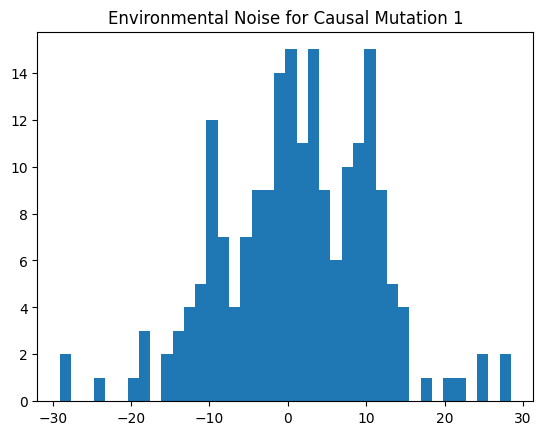

Mean of noise: 1.2544873583906082
Standard deviation of noise: 9.684185877391545


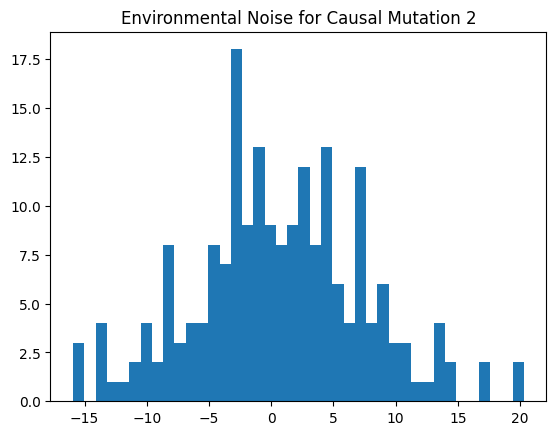

Mean of noise: 0.622089952994172
Standard deviation of noise: 6.91606470981659


In [20]:
df_dict_test_pre_normal = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal)

for i in range(num):
  temp_df = df_dict_test_pre_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [21]:
phenotype_multi_normal_h2_df_normalized = normalize(phenotype_multi_normal_h2, normalize_genetic_values=True)
phenotype_multi_normal_h2_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.045227,0.203392,-0.841835
1,1,0,-0.817347,0.239757,-0.577590
2,0,1,0.175980,-0.073344,0.102636
3,1,1,-0.757935,-0.158640,-0.916575
4,0,2,0.851451,-0.321254,0.530197
...,...,...,...,...,...
395,1,197,1.265690,0.333474,1.599164
396,0,198,-0.380183,0.204170,-0.176013
397,1,198,-0.427607,-0.221602,-0.649209
398,0,199,0.806193,-0.417059,0.389134


In [22]:
df_dict_test_pre_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df_normalized.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal_final)

for i in range(num):
  temp_df = df_dict_test_pre_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0
Variance of the genetic values for Causal Mutation 1 is 0.5036524439092274
Variance of the noise for Causal Mutation 1 is 0.43004428842074577
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.6953785724713739
Variance of the noise for Causal Mutation 2 is 0.23497122082489158


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have already been normalized).

In [23]:
phenotype_post_normalization = sim_env_noise(normalized_individual_multi_normal, h2=[0.25, 0.45]) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization = phenotype_post_normalization.phenotype_df
phenotype_df_post_normalization

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.472805,0.117623,-1.355182
1,1,0,-0.980158,0.019021,-0.961137
2,0,1,0.247969,-0.324216,-0.076247
3,1,1,-0.908911,1.280630,0.371720
4,0,2,1.199759,0.134513,1.334272
...,...,...,...,...,...
395,1,197,1.517808,0.266039,1.783847
396,0,198,-0.535707,-0.175897,-0.711603
397,1,198,-0.512783,-0.136614,-0.649398
398,0,199,1.135988,2.186473,3.322461


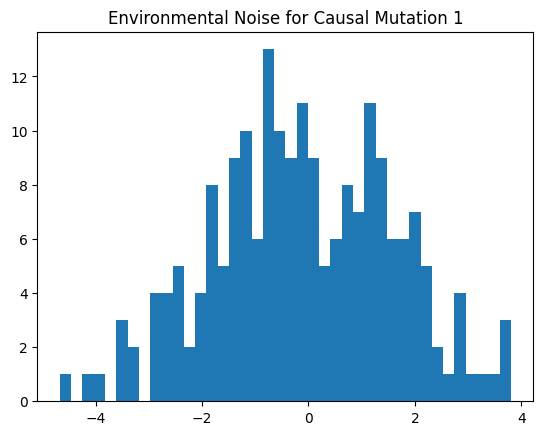

Mean of noise: -0.10691028238105021
Standard deviation of noise: 1.6925389282973016


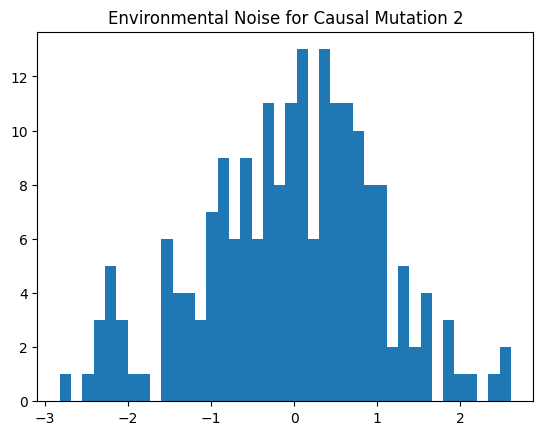

Mean of noise: -0.04745975713312827
Standard deviation of noise: 1.0553560823699768


In [24]:
df_dict_test_post_normal = {k: v.sort_values('individual_id') for k, v in phenotype_df_post_normalization.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal)

for i in range(num):
  temp_df = df_dict_test_post_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_final_df = normalize(phenotype_post_normalization) #normalizing the final dataframe with the phenotypes
phenotype_post_normalization_final_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.771056,0.117550,-0.653506
1,1,0,-0.694363,0.047097,-0.647267
2,0,1,0.129819,-0.113766,0.016053
3,1,1,-0.643890,0.940845,0.296955
4,0,2,0.628109,0.126392,0.754501
...,...,...,...,...,...
395,1,197,1.075245,0.222089,1.297334
396,0,198,-0.280458,-0.036116,-0.316574
397,1,198,-0.363266,-0.063159,-0.426425
398,0,199,0.594723,1.200653,1.795375


In [26]:
df_dict_test_post_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_post_normalization_final_df.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal_final)

for i in range(num):
  temp_df = df_dict_test_post_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0
Variance of the genetic values for Causal Mutation 1 is 0.2740825776458769
Variance of the noise for Causal Mutation 1 is 0.7851610777148648
Variance of the phenotypes for Causal Mutation 2 is 1.0000000000000002
Variance of the genetic values for Causal Mutation 2 is 0.5018585907721134
Variance of the noise for Causal Mutation 2 is 0.5589582849495122
